##### **EXPLORATORY DATA ANALYSIS OF BUREAU DATA** #####

In this notebook we will perform exploratory data analysis (EDA) on the Bureau data to understand its structure, identify patterns, and uncover insights that can inform further analysis. For data analysis we will use DuckDB, a high-performance in-process SQL Online Analytical Processing (OLAP) database management system.

In this notebook we will explore the following datasets:
- `bureau.csv` which contains information about clients' previous credits with other financial institutions.
- `bureau_balance.csv` which contains monthly balances of previous credits in the Bureau dataset.

First, we will load the necessary libraries, connect to DuckDB, make views of the tables and load them to Pandas.

In [1]:
import os
import sys

import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append(os.path.abspath(".."))
from utils import utils
from utils.plot_style import set_notebook_style

set_notebook_style()

In [2]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", 50)
pd.set_option("future.no_silent_downcasting", True)

In [3]:
con = duckdb.connect()

con.execute(
    """
    CREATE OR REPLACE VIEW bureau AS 
    SELECT * FROM '../data/bureau.parquet'
"""
);

In [4]:
con.execute(
    """
    CREATE OR REPLACE VIEW bureau_balance AS 
    SELECT * FROM '../data/bureau_balance.parquet'
"""
);

In [5]:
bureau_overview = con.execute(
    """
    SELECT *
    FROM bureau
"""
).df()

bureau_overview.head(2)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN


In [6]:
bureau_bal_overview = con.execute(
    """
    SELECT *
    FROM bureau_balance
"""
).df()

bureau_bal_overview.head(2)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C


Below we will extract descriptions of the columns in the Bureau data to understand what each column represents.

In [7]:
description = pd.read_csv(
    "../data/HomeCredit_columns_description.csv", encoding="ISO-8859-1", index_col=0
)
description[description["Table"].str.startswith("bureau")]

,Table,Row,Description,Special
125,bureau.csv,SK_ID_CURR,"ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau",hashed
126,bureau.csv,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application),hashed
127,bureau.csv,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits,NaN
128,bureau.csv,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit,recoded
129,bureau.csv,DAYS_CREDIT,How many days before current application did client apply for Credit Bureau credit,time only relative to the application
130,bureau.csv,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the time of application for related loan in our sample,NaN
131,bureau.csv,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at the time of application in Home Credit,time only relative to the application
132,bureau.csv,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of application in Home Credit (only for closed credit),time only relative to the application
133,bureau.csv,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample),NaN
134,bureau.csv,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit prolonged,NaN


##### **Bureau_balance.csv EDA** #####

In this section we will perform EDA on the `bureau_balance.csv` dataset.

In [8]:
print(f"Bureau_balance.csv file has {bureau_bal_overview.shape[0]:,} rows and \
{bureau_bal_overview.shape[1]} columns.")

Bureau_balance.csv file has 27,299,925 rows and 3 columns.


We see that bureau_balance.csv contains monthly data about the status of previous credits in Bureau for each client.

In [9]:
print(
    f"Number of duplicated rows in bureau_balance.csv file is: {bureau_bal_overview.duplicated().sum()}."
)

Number of duplicated rows in bureau_balance.csv file is: 0.


In [10]:
print("Number of missing values in each column of bureau_balance.csv file is:")
bureau_bal_overview.isnull().sum()

Number of missing values in each column of bureau_balance.csv file is:


SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [11]:
bureau_bal_overview.describe(include="all").map(
    lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x
)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
count,"27,299,925.00","27,299,925.00",27299925
unique,nan,nan,8.00
top,nan,nan,C
freq,nan,nan,13646993
mean,"6,036,297.33",-30.74,nan
std,"492,348.86",23.86,nan
min,"5,001,709.00",-96.00,nan
25%,"5,730,933.00",-46.00,nan
50%,"6,070,821.00",-25.00,nan
75%,"6,431,951.00",-11.00,nan


We see that the bureau_balance table contains monthly information about the status of previous credits in other financial institutions for each client. The data spans multiple months for each credit, as indicated by the MONTHS_BALANCE column. The STATUS column provides insights into the payment status of these credits, with various codes representing different states such as on-time payments, delays, and closed accounts. -96 months (8 years) from the current month is the earliest month in the data.

In [12]:
bureau_bal_overview.MONTHS_BALANCE.value_counts().loc[0]

610965

We see that there are 610 k records with balance for the month of application. Below we will look at the distribution of STATUS for these records. We can see that most of the records have status 'C' (closed), '0' (on time) or 'X' (unknown).

In [13]:
bureau_bal_overview.STATUS.value_counts(normalize=True).map(lambda x: f"{x:.2%}")

STATUS
C    49.99%
0    27.47%
X    21.28%
1     0.89%
5     0.23%
2     0.09%
3     0.03%
4     0.02%
Name: proportion, dtype: object

Now we will aggregate the bureau_balance data by SK_ID_BUREAU to get a summary of the status of each credit.

In [14]:
bureau_bal_summary = con.execute(
    """SELECT
            SK_ID_BUREAU,
                COUNT(MONTHS_BALANCE) AS MONTHS_COUNT,
                SUM(CASE WHEN STATUS = 'C' THEN 1 ELSE 0 END) AS CLOSED_COUNT,
                SUM(CASE WHEN STATUS = 'X' THEN 1 ELSE 0 END) AS UNKNOWN_COUNT,
                SUM(CASE WHEN STATUS = '0' THEN 1 ELSE 0 END) AS ON_TIME_COUNT,
                SUM(CASE WHEN STATUS = '1' THEN 1 ELSE 0 END) AS DPD_1_30_COUNT,
                SUM(CASE WHEN STATUS = '2' THEN 1 ELSE 0 END) AS DPD_31_60_COUNT,
                SUM(CASE WHEN STATUS = '3' THEN 1 ELSE 0 END) AS DPD_61_90_COUNT,
                SUM(CASE WHEN STATUS = '4' THEN 1 ELSE 0 END) AS DPD_91_120_COUNT,
                SUM(CASE WHEN STATUS = '5' THEN 1 ELSE 0 END) AS DPD_120_COUNT,
                SUM(CASE WHEN STATUS IN ('1', '2', '3', '4', '5') THEN 1 ELSE 0 END) AS TOTAL_DPD_COUNT,
                
                AVG(CASE WHEN STATUS = 'C' THEN 1 ELSE 0 END) AS CLOSED_RATIO,
                AVG(CASE WHEN STATUS = 'X' THEN 1 ELSE 0 END) AS UNKNOWN_RATIO,
                AVG(CASE WHEN STATUS = '0' THEN 1 ELSE 0 END) AS ON_TIME_RATIO,
                AVG(CASE WHEN STATUS = '1' THEN 1 ELSE 0 END) AS DPD_1_30_RATIO,
                AVG(CASE WHEN STATUS = '2' THEN 1 ELSE 0 END) AS DPD_31_60_RATIO,
                AVG(CASE WHEN STATUS = '3' THEN 1 ELSE 0 END) AS DPD_61_90_RATIO,
                AVG(CASE WHEN STATUS = '4' THEN 1 ELSE 0 END) AS DPD_91_120_RATIO,
                AVG(CASE WHEN STATUS = '5' THEN 1 ELSE 0 END) AS DPD_120_RATIO,
                AVG(CASE WHEN STATUS IN ('1', '2', '3', '4', '5') THEN 1 ELSE 0 END) AS TOTAL_DPD_RATIO,
                
                MAX(CASE WHEN STATUS = '5' THEN 5
                        WHEN STATUS = '4' THEN 4
                        WHEN STATUS = '3' THEN 3
                        WHEN STATUS = '2' THEN 2
                        WHEN STATUS = '1' THEN 1
                        ELSE 0 END) AS MAX_DPD_STATUS,    
                        
                MAX(CASE WHEN STATUS IN ('1', '2', '3', '4', '5') THEN MONTHS_BALANCE ELSE 0 END) AS FIRST_DPD_MONTH,
                MIN(CASE WHEN STATUS IN ('1', '2', '3', '4', '5') THEN MONTHS_BALANCE ELSE 0 END) AS LAST_DPD_MONTH,
                
                MIN(MONTHS_BALANCE) AS MIN_MONTHS_BALANCE,
                MAX(MONTHS_BALANCE) AS MAX_MONTHS_BALANCE
            FROM bureau_balance
            GROUP BY SK_ID_BUREAU
            """
).df()

In [15]:
print(f"After aggregation we have dataframe of the shape: {bureau_bal_summary.shape}.")

After aggregation we have dataframe of the shape: (817395, 25).


Additionally, we will add the feature of the time span between the earliest and latest month recorded for each credit.

In [16]:
bureau_bal_summary["MAX_MIN_MONTHS_DIFF"] = (
    bureau_bal_summary["MAX_MONTHS_BALANCE"] - bureau_bal_summary["MIN_MONTHS_BALANCE"]
)

In [17]:
print(
    f"There are {bureau_bal_summary.isnull().sum().sum()} missing values in the aggregated bureau_balance dataframe."
)

There are 0 missing values in the aggregated bureau_balance dataframe.


##### **Bureau.csv EDA** ####

Next is bureau.csv table which contains information about clients' previous credits with other financial institutions. For every loan in train dataset, there are several previous loans recorded in this table. 

In [18]:
print(f"The shape of the bureau.csv file is: {bureau_overview.shape}.")
print(f"The amount of duplicated rows is: {bureau_overview.duplicated().sum()}.")

The shape of the bureau.csv file is: (1716428, 17).
The amount of duplicated rows is: 0.


In [19]:
print("Number of missing values in each column of bureau.csv file:")
bureau_overview.isnull().sum()

Number of missing values in each column of bureau.csv file:


SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

We see that several columns in bureau.csv table have quite a lot of missing values. Below we will check data types of the table.

In [20]:
bureau_overview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


Now we will check categorical columns in bureau.csv to see the distribution of the values. Additionally we will explore distributions of numerical columns in bureau.csv to understand their characteristics and spot any potential outliers or anomalies.

In [21]:
for col in bureau_overview.select_dtypes(include="object").columns:
    print(bureau_overview[col].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))
    print()

CREDIT_ACTIVE
Closed      62.88%
Active      36.74%
Sold         0.38%
Bad debt     0.00%
Name: proportion, dtype: object

CREDIT_CURRENCY
currency 1    99.92%
currency 2     0.07%
currency 3     0.01%
currency 4     0.00%
Name: proportion, dtype: object

CREDIT_TYPE
Consumer credit                                 72.92%
Credit card                                     23.43%
Car loan                                         1.61%
Mortgage                                         1.07%
Microloan                                        0.72%
Loan for business development                    0.12%
Another type of loan                             0.06%
Unknown type of loan                             0.03%
Loan for working capital replenishment           0.03%
Cash loan (non-earmarked)                        0.00%
Real estate loan                                 0.00%
Loan for the purchase of equipment               0.00%
Loan for purchase of shares (margin lending)     0.00%
Mobile operator l

We see that ~63% of the loans were closed, the rest being active. Main currency for all the loans was currency 1. ~73% were consumer credits and ~23% were credit cards.

For numerical columns we will look at summary statistics and distributions of each feature.

**CNT_CREDIT_PROLONG**

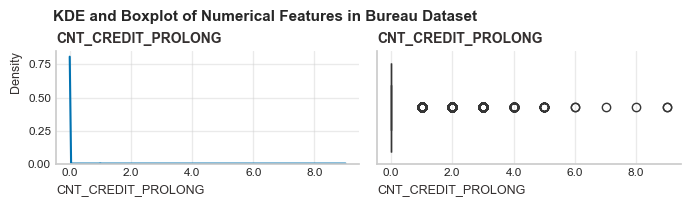

Missing Value Summary:
CNT_CREDIT_PROLONG: 0 missing


,count,mean,std,min,25%,50%,75%,max
CNT_CREDIT_PROLONG,"1,716,428.0",0.0,0.1,0.0,0.0,0.0,0.0,9.0


In [22]:
utils.get_distribution_plots_with_stat(
    bureau_overview, ["CNT_CREDIT_PROLONG"], right=0.38, top=1.02
)

We see that most of the credits were not prolonged, with only a small fraction being prolonged multiple times.

In [23]:
bureau_overview[
    bureau_overview["CNT_CREDIT_PROLONG"] > 1
].CNT_CREDIT_PROLONG.value_counts()

CNT_CREDIT_PROLONG
2    1222
3     191
4      54
5      21
9       2
6       2
8       1
7       1
Name: count, dtype: int64

We can notice that most of the credits were prolonged 2 times, but some credits were prolonged up to 9 times. We will leave this feature as is since it may contain useful information.

**AMT_CREDIT_SUM**

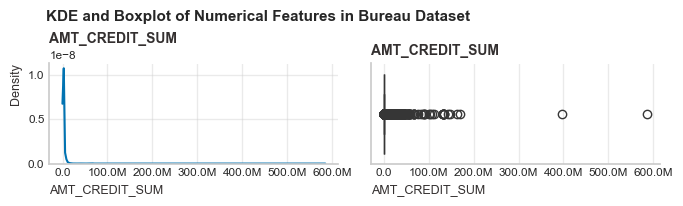

Missing Value Summary:
AMT_CREDIT_SUM: 13 missing


,count,mean,std,min,25%,50%,75%,max
AMT_CREDIT_SUM,"1,716,415.0","354,994.6","1,149,811.3",0.0,"51,300.0","125,518.5","315,000.0","585,000,000.0"


In [24]:
utils.get_distribution_plots_with_stat(
    bureau_overview, ["AMT_CREDIT_SUM"], right=0.38, top=1.02
)

In [25]:
bureau_overview[bureau_overview.AMT_CREDIT_SUM.gt(2e8)]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
907821,325979,5671169,Closed,currency 1,-2867,0,-2833.0,-2830.0,NaN,0,396000000.0,0.0,0.0,0.0,Consumer credit,-1400,NaN
1515147,386819,6706880,Closed,currency 1,-2683,0,-2318.0,-2312.0,NaN,0,585000000.0,NaN,NaN,0.0,Consumer credit,-2312,NaN


We see that there are a few outliers with very high credit amounts. We will replace these values with the median of the consumer credits. Also, we will create missing value indicator for this column.

In [26]:
credit_anomaly = bureau_overview["AMT_CREDIT_SUM"].gt(2e8)
bureau_overview["CREDIT_SUM_ANOMALY"] = credit_anomaly

bureau_overview.loc[credit_anomaly, "AMT_CREDIT_SUM"] = np.nan
median_credit = bureau_overview.loc[
    bureau_overview["CREDIT_TYPE"] == "Consumer credit", "AMT_CREDIT_SUM"
].median()
bureau_overview.loc[credit_anomaly, "AMT_CREDIT_SUM"] = median_credit

bureau_overview["MISSING_CREDIT_SUM"] = (
    bureau_overview["AMT_CREDIT_SUM"].isnull().astype(int)
)

**AMT_CREDIT_SUM_DEBT**

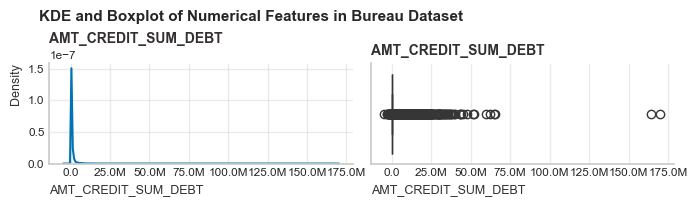

Missing Value Summary:
AMT_CREDIT_SUM_DEBT: 257669 missing


,count,mean,std,min,25%,50%,75%,max
AMT_CREDIT_SUM_DEBT,"1,458,759.0","137,085.1","677,401.1","-4,705,600.3",0.0,0.0,"40,153.5","170,100,000.0"


In [27]:
utils.get_distribution_plots_with_stat(
    bureau_overview, ["AMT_CREDIT_SUM_DEBT"], right=0.37, top=1.02
)

We see that AMT_CREDIT_SUM_DEBT has a few outliers with very high debt amounts. We will mark these values as anomalies and impute them with median value of credit sum debt for consumer credits. We will create missing value indicator for this column as well.

In [28]:
bureau_overview[bureau_overview.AMT_CREDIT_SUM_DEBT.gt(1.5e8)]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM
488411,363076,5089138,Active,currency 1,-1127,0,-675.0,NaN,NaN,0,164032200.0,164032200.0,NaN,0.0,Consumer credit,-473,NaN,False,0
489961,363076,5090928,Active,currency 1,-1006,0,-675.0,NaN,NaN,0,170100000.0,170100000.0,NaN,0.0,Consumer credit,-473,NaN,False,0


In [29]:
bureau_overview[bureau_overview.AMT_CREDIT_SUM_DEBT.lt(0)].CREDIT_TYPE.value_counts()

CREDIT_TYPE
Credit card    8418
Name: count, dtype: int64

We see that cases where credit debt is less than zero are for credit cards.

In [30]:
bureau_overview[bureau_overview.AMT_CREDIT_SUM_DEBT.gt(0)].CREDIT_TYPE.value_counts()

CREDIT_TYPE
Consumer credit                           258063
Credit card                               153055
Mortgage                                   11324
Car loan                                    8243
Microloan                                   2354
Loan for business development                364
Loan for working capital replenishment       189
Another type of loan                         144
Unknown type of loan                         115
Cash loan (non-earmarked)                     42
Real estate loan                               9
Loan for the purchase of equipment             4
Mobile operator loan                           1
Name: count, dtype: int64

Credit debt is positive for other types of credits, including credit cards, as well.

In [31]:
bureau_overview[bureau_overview.AMT_CREDIT_SUM_DEBT.lt(0)].sort_values(
    by="AMT_CREDIT_SUM_DEBT", ascending=True
).head(5)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM
82859,316058,5262220,Active,currency 1,-774,0,1016.0,NaN,0.0,0,0.0,-4705600.32,4705600.32,0.0,Credit card,-628,NaN,False,0
518329,187109,6461787,Active,currency 1,-880,0,842.0,NaN,0.0,0,0.0,-3109510.98,3109510.98,0.0,Credit card,-656,NaN,False,0
775308,268156,5406590,Active,currency 1,-1193,0,-500.0,NaN,0.0,0,4500.0,-2796723.72,2801223.72,0.0,Credit card,-675,NaN,False,0
82858,316058,5262219,Active,currency 1,-924,0,834.0,NaN,0.0,0,0.0,-2273021.73,2273021.73,0.0,Credit card,-621,NaN,False,0
720176,146988,6493134,Active,currency 1,-1160,0,678.0,NaN,0.0,0,675000.0,-2167229.34,2167229.34,0.0,Credit card,-659,NaN,False,0


We see that for credit cards total credit is the feature AMT_CREDIT_SUM_LIMIT, and available credit is AMT_CREDIT_SUM. Let's examine if the debt is positive in any cases.

In [32]:
bureau_overview[bureau_overview.AMT_CREDIT_SUM_DEBT.gt(0)].sort_values(
    by="AMT_CREDIT_SUM_DEBT", ascending=True
).head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM
721327,279010,6494625,Active,currency 1,-2262,2108,-2047.0,NaN,0.00,0,48787.11,0.045,0.000,0.0,Consumer credit,-1586,NaN,False,0
107907,359548,6587394,Active,currency 1,-1044,0,-710.0,NaN,NaN,0,15265.35,0.135,NaN,0.0,Consumer credit,-14,NaN,False,0
1296303,287888,6333924,Active,currency 1,-711,0,-316.0,NaN,NaN,0,89663.76,0.135,NaN,0.0,Consumer credit,-142,NaN,False,0
1689746,307591,5577961,Active,currency 1,-1544,0,977.0,NaN,194.94,0,0.00,0.135,-0.135,0.0,Credit card,-631,NaN,False,0
1477665,428657,5350540,Active,currency 1,-940,0,834.0,NaN,0.00,0,0.00,0.180,-0.180,0.0,Credit card,-637,NaN,False,0


It seems for consumer credits we have AMT_CREDIT_SUM feature as the available credit, for credit cards positive debt is the overpayment from the client side. So if AMT_CREDIT_SUM is the available credit for the client, AMT_CREDIT_SUM_LIMIT is negative when the client has no available credit sum.

Let's handle two anomalous credit sum debt values and fill them with median values of the feature.

In [33]:
credit_debt_anomaly = bureau_overview["AMT_CREDIT_SUM_DEBT"].gt(1.5e8)
bureau_overview["CREDIT_SUM_DEBT_ANOMALY"] = credit_debt_anomaly

bureau_overview.loc[credit_debt_anomaly, "AMT_CREDIT_SUM_DEBT"] = np.nan
median_credit_debt = bureau_overview.loc[
    bureau_overview["CREDIT_TYPE"] == "Consumer credit", "AMT_CREDIT_SUM_DEBT"
].median()
bureau_overview.loc[credit_debt_anomaly, "AMT_CREDIT_SUM_DEBT"] = median_credit_debt

bureau_overview["MISSING_CREDIT_SUM_DEBT"] = (
    bureau_overview["AMT_CREDIT_SUM_DEBT"].isnull().astype(int)
)

**AMT_CREDIT_MAX_OVERDUE**

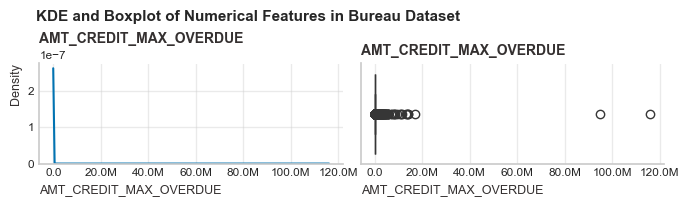

Missing Value Summary:
AMT_CREDIT_MAX_OVERDUE: 1124488 missing


,count,mean,std,min,25%,50%,75%,max
AMT_CREDIT_MAX_OVERDUE,"591,940.0","3,825.4","206,031.6",0.0,0.0,0.0,0.0,"115,987,185.0"


In [34]:
utils.get_distribution_plots_with_stat(
    bureau_overview, ["AMT_CREDIT_MAX_OVERDUE"], right=0.38, top=1.02
)

Below we will examine a few extreme values of AMT_CREDIT_MAX_OVERDUE to see if they are valid.

In [35]:
bureau_overview[bureau_overview.AMT_CREDIT_MAX_OVERDUE.gt(0.2e8)]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT
731333,406694,6376438,Closed,currency 1,-2412,0,4870.0,-657.0,115987185.0,0,15300000.0,NaN,NaN,0.0,Mortgage,-651,0.0,False,0,False,1
819016,212399,6793130,Closed,currency 1,-2613,0,2856.0,-467.0,94812246.0,0,20763697.5,NaN,NaN,0.0,Mortgage,-467,NaN,False,0,False,1


In [36]:
bureau_overview.groupby("CREDIT_TYPE")["AMT_CREDIT_MAX_OVERDUE"].median().sort_values(
    ascending=False
)

CREDIT_TYPE
Loan for the purchase of equipment              62437.5
Another type of loan                                0.0
Car loan                                            0.0
Cash loan (non-earmarked)                           0.0
Consumer credit                                     0.0
Credit card                                         0.0
Loan for business development                       0.0
Loan for working capital replenishment              0.0
Microloan                                           0.0
Mobile operator loan                                0.0
Mortgage                                            0.0
Real estate loan                                    0.0
Unknown type of loan                                0.0
Interbank credit                                    NaN
Loan for purchase of shares (margin lending)        NaN
Name: AMT_CREDIT_MAX_OVERDUE, dtype: float64

We can notice that by credit type only loans for the purchase of equipment have median maximum overdue amount greater than zero. 

Now we will examine AMT_CREDIT_MAX_OVERDUE values which exceed AMT_CREDIT_SUM. We got about 3k rows where the maximum overdue amount is greater than the total credit amount. We will look at a few of these records to see if they are valid.

In [37]:
max_overdue_anomaly = (
    bureau_overview["AMT_CREDIT_MAX_OVERDUE"] > bureau_overview["AMT_CREDIT_SUM"]
)
print(bureau_overview[max_overdue_anomaly].shape[0], "rows")
bureau_overview[max_overdue_anomaly].head()

2945 rows


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT
521,122858,5715142,Closed,currency 1,-895,0,NaN,-353.0,8696.52,0,0.0,0.0,0.0,0.0,Credit card,-287,NaN,False,0,False,0
567,417740,5715198,Closed,currency 1,-2711,0,NaN,-873.0,4752.00,0,0.0,0.0,0.0,0.0,Credit card,-828,NaN,False,0,False,0
1072,370938,5715797,Active,currency 1,-802,0,NaN,NaN,450.00,0,4.5,0.0,4.5,0.0,Credit card,-21,3390.66,False,0,False,0
1302,299829,5716062,Closed,currency 1,-828,0,10129.0,-430.0,28246.50,0,0.0,NaN,NaN,0.0,Credit card,-430,NaN,False,0,False,1
1306,299700,5716067,Active,currency 1,-2252,0,8752.0,NaN,468.00,1,0.0,NaN,NaN,0.0,Credit card,-930,NaN,False,0,False,1


It seems strange that max overdue amount is greater than total credit amount looking at active credits. We will mark these values as anomalies and impute them with AMT_CREDIT_SUM_DEBT. We will create missing value indicator for this column as well.

Additionally, we will impute with the median value of Mortgages a few anomalous values of AMT_CREDIT_MAX_OVERDUE.

In [38]:
bureau_overview["MAX_OVERDUE_ANOMALY"] = max_overdue_anomaly

bureau_overview.loc[max_overdue_anomaly, "AMT_CREDIT_MAX_OVERDUE"] = (
    bureau_overview.loc[max_overdue_anomaly, "AMT_CREDIT_SUM_DEBT"]
)

bureau_overview["MISSING_MAX_OVERDUE"] = (
    bureau_overview["AMT_CREDIT_MAX_OVERDUE"].isnull().astype(int)
)

In [39]:
extreme_max_overdue_anomaly = bureau_overview.AMT_CREDIT_MAX_OVERDUE.gt(0.2e8)
bureau_overview["OVERDUE_ANOMALY"] = extreme_max_overdue_anomaly
bureau_overview.loc[extreme_max_overdue_anomaly, "AMT_CREDIT_MAX_OVERDUE"] = np.nan
median_overdue = bureau_overview.loc[
    bureau_overview["CREDIT_TYPE"] == "Mortgage", "AMT_CREDIT_MAX_OVERDUE"
].median()

bureau_overview.loc[extreme_max_overdue_anomaly, "AMT_CREDIT_MAX_OVERDUE"] = (
    median_overdue
)

**AMT_CREDIT_SUM_LIMIT**

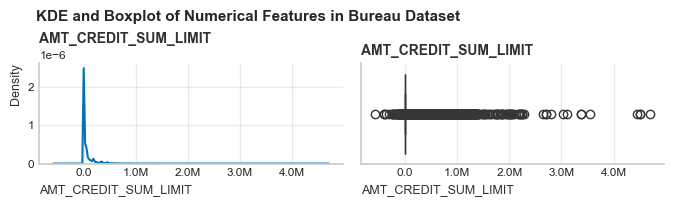

Missing Value Summary:
AMT_CREDIT_SUM_LIMIT: 591780 missing


,count,mean,std,min,25%,50%,75%,max
AMT_CREDIT_SUM_LIMIT,"1,124,648.0","6,229.5","45,032.0","-586,406.1",0.0,0.0,0.0,"4,705,600.3"


In [40]:
utils.get_distribution_plots_with_stat(
    bureau_overview, ["AMT_CREDIT_SUM_LIMIT"], right=0.38, top=1.02
)

Below we will examine a few extreme values of AMT_CREDIT_SUM_LIMIT to see if they are valid.

In [41]:
bureau_overview[bureau_overview["AMT_CREDIT_SUM_LIMIT"].gt(4e6)]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY
82859,316058,5262220,Active,currency 1,-774,0,1016.0,NaN,0.0,0,0.0,-4705600.32,4705600.32,0.0,Credit card,-628,NaN,False,0,False,0,False,0,False
882676,267090,6802939,Active,currency 1,-660,0,NaN,NaN,0.0,0,4500000.0,0.00,4500000.00,0.0,Credit card,-17,450000.0,False,0,False,0,False,0,False
1247771,404576,6613130,Active,currency 1,-53,0,1070.0,NaN,0.0,0,4500000.0,0.00,4500000.00,0.0,Credit card,-15,NaN,False,0,False,0,False,0,False
1430873,217276,6718437,Active,currency 1,-933,0,NaN,NaN,0.0,0,4500000.0,56745.00,4443255.00,0.0,Credit card,-5,NaN,False,0,False,0,False,0,False


In [42]:
bureau_overview[bureau_overview["AMT_CREDIT_SUM_LIMIT"].lt(-4e5)]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY
874976,265193,6280591,Active,currency 1,-773,0,322.0,NaN,20229.39,0,450000.0,1036406.115,-586406.115,0.0,Credit card,-240,0.0,False,0,False,0,False,0,False
1600560,134283,5335423,Active,currency 1,-409,0,687.0,NaN,0.00,0,225000.0,626346.945,-401346.945,0.0,Credit card,-189,NaN,False,0,False,0,False,0,False


From the credit sum perspective we see that such credit sum is quite plausible, so we won't change credit sum limit in those extreme cases not to mess up the math between debt, limit and credit sum.

In [43]:
bureau_overview[
    bureau_overview["AMT_CREDIT_SUM_LIMIT"].lt(0)
].CREDIT_TYPE.value_counts()

CREDIT_TYPE
Credit card    351
Name: count, dtype: int64

We see that negative values of AMT_CREDIT_SUM_LIMIT are present only for credit cards. We will leave them as is for now.

In [44]:
bureau_overview[bureau_overview["AMT_CREDIT_SUM_LIMIT"].lt(0)].head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY
1966,319729,5716893,Active,currency 1,-2782,0,1272.0,NaN,24243.480,0,180000.0,680779.440,-5779.440,0.0,Credit card,-558,NaN,False,0,False,0,False,0,False
7774,436084,5723858,Sold,currency 1,-2835,0,-2094.0,-2436.0,785293.605,0,225000.0,785293.605,-110293.605,0.0,Credit card,-2332,NaN,False,0,False,0,True,0,False
17054,131849,5190606,Active,currency 1,-366,0,730.0,NaN,0.000,0,45000.0,56413.260,-11413.260,0.0,Credit card,-158,NaN,False,0,False,0,False,0,False
17952,442762,5191738,Active,currency 1,-744,0,1078.0,NaN,0.000,0,450000.0,653852.385,-1352.385,0.0,Credit card,-495,NaN,False,0,False,0,False,0,False
20661,445702,5195104,Active,currency 1,-685,0,1151.0,NaN,0.000,0,450000.0,463834.305,-13834.305,0.0,Credit card,-434,NaN,False,0,False,0,False,0,False


Here we see the inconsistent relationship between AMT_CREDIT_SUM_DEBT, AMT_CREDIT_SUM_LIMIT and AMT_CREDIT_SUM features: for some cases positive debt with negative credit limit equals to credit sum (as available credit), but in some cases the math doesn't work.

In [45]:
bureau_overview[bureau_overview["AMT_CREDIT_SUM_LIMIT"].gt(0)].head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.0,71017.380,108982.620,0.0,Credit card,-31,NaN,False,0,False,0,False,0,False
20,238881,5714489,Active,currency 1,-392,0,NaN,NaN,0.0,0,252000.0,23679.000,228320.100,0.0,Credit card,-22,NaN,False,0,False,0,False,0,False
21,222183,5714491,Active,currency 1,-784,0,1008.0,NaN,0.0,0,0.0,-411.615,411.615,0.0,Credit card,-694,NaN,False,0,False,0,False,0,False
75,303740,5714554,Active,currency 1,-581,0,NaN,NaN,0.0,0,384750.0,263056.500,121690.170,0.0,Credit card,-22,NaN,False,0,False,0,False,0,False
87,119939,5714568,Closed,currency 1,-1447,0,-331.0,-1272.0,0.0,0,99000.0,-2692.170,137692.170,0.0,Credit card,-1272,NaN,False,0,False,0,False,0,False


In [46]:
checking_logic = (
    bureau_overview["AMT_CREDIT_SUM_DEBT"] + bureau_overview["AMT_CREDIT_SUM_LIMIT"]
    == bureau_overview["AMT_CREDIT_SUM"]
)

In [47]:
checking_logic.value_counts(normalize=True).map(lambda x: f"{x:.2%}")

False    93.79%
True      6.21%
Name: proportion, dtype: object

We can notice most of the cases AMT_CREDIT_SUM doesn't equal to AMT_CREDIT_SUM_LIMIT plus AMT_CREDIT_SUM_DEBT. We will explore a few of these records to see if they are valid.

In [48]:
bureau_overview[~checking_logic].head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,False,0,False,0,False,1,False
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,False,0,False,0,False,1,False
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,False,0,False,1,False,1,False
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,False,0,False,1,False,1,False
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,False,0,False,1,False,0,False


In [49]:
bureau_overview[checking_logic].head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.0,71017.380,108982.620,0.0,Credit card,-31,NaN,False,0,False,0,False,0,False
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,42103.8,42103.800,0.000,0.0,Consumer credit,-22,NaN,False,0,False,0,False,0,False
14,238881,5714482,Closed,currency 1,-318,0,-187.0,-187.0,NaN,0,0.0,0.000,0.000,0.0,Credit card,-185,NaN,False,0,False,0,False,1,False
21,222183,5714491,Active,currency 1,-784,0,1008.0,NaN,0.0,0,0.0,-411.615,411.615,0.0,Credit card,-694,NaN,False,0,False,0,False,0,False
88,119939,5714569,Closed,currency 1,-1390,0,-331.0,-1263.0,0.0,0,135000.0,-149.040,135149.040,0.0,Credit card,-1263,NaN,False,0,False,0,False,0,False


So we will include additional feature to represent this inconsistency and add missing value indicator for this feature as well.

In [50]:
bureau_overview["CRED_DEBT_LIMIT_MISMATCH_CRED_SUM"] = checking_logic
bureau_overview["MISSING_CREDIT_LIMIT"] = (
    bureau_overview["AMT_CREDIT_SUM_LIMIT"].isnull().astype(int)
)

**AMT_CREDIT_SUM_OVERDUE**

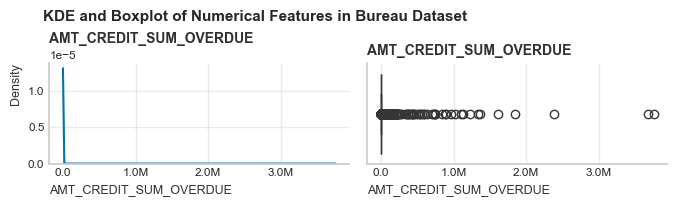

Missing Value Summary:
AMT_CREDIT_SUM_OVERDUE: 0 missing


,count,mean,std,min,25%,50%,75%,max
AMT_CREDIT_SUM_OVERDUE,"1,716,428.0",37.9,"5,937.7",0.0,0.0,0.0,0.0,"3,756,681.0"


In [51]:
utils.get_distribution_plots_with_stat(
    bureau_overview, ["AMT_CREDIT_SUM_OVERDUE"], right=0.385, top=1.02
)

We will examine a few extreme values of AMT_CREDIT_SUM_OVERDUE to see if they are valid.

In [52]:
bureau_overview[bureau_overview.AMT_CREDIT_SUM_OVERDUE.gt(2e6)]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY,CRED_DEBT_LIMIT_MISMATCH_CRED_SUM,MISSING_CREDIT_LIMIT
188140,121845,5786119,Active,currency 1,-1582,1428,244.0,NaN,NaN,0,2250000.0,4075335.0,0.0,2387232.0,Consumer credit,-180,NaN,False,0,False,0,False,1,False,False,0
940407,355093,6291105,Active,currency 1,-2762,1670,-1666.0,NaN,NaN,0,3600000.0,0.0,0.0,3756681.0,Consumer credit,-137,NaN,False,0,False,0,False,1,False,False,0
1689290,435405,5577375,Active,currency 1,-1699,1541,-970.0,NaN,NaN,0,3690000.0,3681063.0,NaN,3681063.0,Credit card,-37,NaN,False,0,False,0,False,1,False,False,1


We will mark those extreme values as anomalies and replace them with median value for the feature. 

In [53]:
credit_overdue_anomaly = bureau_overview["AMT_CREDIT_SUM_OVERDUE"].gt(2e6)
bureau_overview["CREDIT_SUM_OVERDUE_ANOMALY"] = credit_overdue_anomaly

bureau_overview.loc[credit_overdue_anomaly, "AMT_CREDIT_SUM_OVERDUE"] = np.nan
median_credit_overdue = bureau_overview.AMT_CREDIT_SUM_OVERDUE.median()
bureau_overview.loc[credit_overdue_anomaly, "AMT_CREDIT_SUM_OVERDUE"] = (
    median_credit_overdue
)

**DAYS_CREDIT_UPDATE**

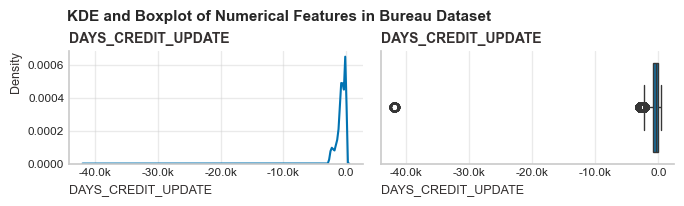

Missing Value Summary:
DAYS_CREDIT_UPDATE: 0 missing


,count,mean,std,min,25%,50%,75%,max
DAYS_CREDIT_UPDATE,"1,716,428.0",-593.7,720.7,"-41,947.0",-908.0,-395.0,-33.0,372.0


In [54]:
utils.get_distribution_plots_with_stat(
    bureau_overview, ["DAYS_CREDIT_UPDATE"], right=0.41, top=1.02
)

Let's check how many samples have DAYS_CREDIT_UPDATE greater than the application day (0), and less than 41k days (~112 years).

In [55]:
bureau_overview[bureau_overview.DAYS_CREDIT_UPDATE.gt(0)].shape[0]

17

In [56]:
bureau_overview[bureau_overview.DAYS_CREDIT_UPDATE.lt(-4.1e4)].shape[0]

95

In [57]:
bureau_overview[bureau_overview.DAYS_CREDIT_UPDATE.lt(-4.1e4)].head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY,CRED_DEBT_LIMIT_MISMATCH_CRED_SUM,MISSING_CREDIT_LIMIT,CREDIT_SUM_OVERDUE_ANOMALY
1943,219708,5716863,Closed,currency 1,-331,0,765.0,-208.0,0.0,0,16414.245,0.0,16414.245,0.0,Credit card,-41857,NaN,False,0,False,0,False,0,False,True,0,False
25051,448220,5200446,Closed,currency 1,-488,0,608.0,-457.0,0.0,0,72859.500,0.0,72859.500,0.0,Credit card,-41913,NaN,False,0,False,0,False,0,False,True,0,False
30474,380623,5800600,Active,currency 1,-281,0,815.0,NaN,0.0,0,225000.000,0.0,NaN,0.0,Credit card,-41906,NaN,False,0,False,0,False,0,False,False,1,False
30531,127624,5800677,Closed,currency 1,-364,0,732.0,-294.0,0.0,0,450000.000,0.0,450000.000,0.0,Credit card,-41886,NaN,False,0,False,0,False,0,False,True,0,False
60385,214335,5238926,Active,currency 1,-311,0,785.0,NaN,0.0,0,90000.000,0.0,NaN,0.0,Credit card,-41934,NaN,False,0,False,0,False,0,False,False,1,False


We must check how many records have DAYS_CREDIT_UPDATE less than DAYS_CREDIT, and create a feature to represent this inconsistency.

In [58]:
days_mismatch = bureau_overview["DAYS_CREDIT"] > bureau_overview["DAYS_CREDIT_UPDATE"]
days_mismatch.value_counts()

False    1716293
True         135
Name: count, dtype: int64

In [59]:
bureau_overview["DAYS_CRED_OVERDUE_MISMATCH"] = days_mismatch

Now we will mark samples were DAYS_CREDIT_UPDATE is less than DAYS_CREDIT or are greater than zero creating a feature to represent this inconsistency. We will impute past anomalies with median value and future anomalies with 0 (application day).

In [60]:
min_days_credit = bureau_overview.DAYS_CREDIT.min()

days_update_anomalies_all = (
    bureau_overview["DAYS_CREDIT_UPDATE"].lt(min_days_credit)
) | (bureau_overview["DAYS_CREDIT_UPDATE"].gt(0))

past_anomalies = bureau_overview["DAYS_CREDIT_UPDATE"].lt(min_days_credit)

future_anomalies = bureau_overview["DAYS_CREDIT_UPDATE"].gt(0)

bureau_overview["DAYS_UPDATE_ANOMALY"] = days_update_anomalies_all

bureau_overview.loc[days_update_anomalies_all, "DAYS_CREDIT_UPDATE"] = np.nan
median_days_update = bureau_overview.DAYS_CREDIT_UPDATE.median()

bureau_overview.loc[future_anomalies, "DAYS_CREDIT_UPDATE"] = 0
bureau_overview.loc[past_anomalies, "DAYS_CREDIT_UPDATE"] = median_days_update

**CREDIT DAY OVERDUE**

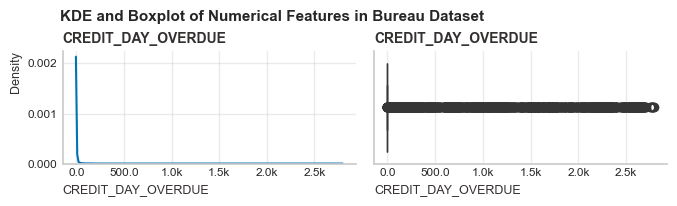

Missing Value Summary:
CREDIT_DAY_OVERDUE: 0 missing


,count,mean,std,min,25%,50%,75%,max
CREDIT_DAY_OVERDUE,"1,716,428.0",0.8,36.5,0.0,0.0,0.0,0.0,"2,792.0"


In [61]:
utils.get_distribution_plots_with_stat(
    bureau_overview, ["CREDIT_DAY_OVERDUE"], right=0.41, top=1.02
)

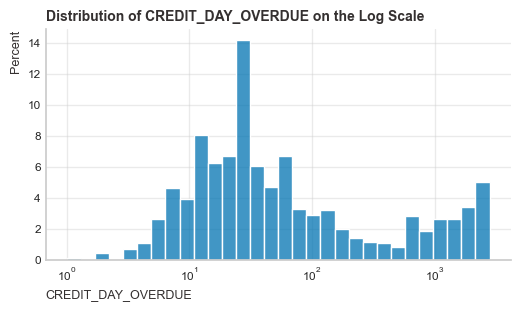

In [62]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.histplot(bureau_overview.CREDIT_DAY_OVERDUE, log_scale=True, stat="percent", ax=ax)
plt.title("Distribution of CREDIT_DAY_OVERDUE on the Log Scale")
plt.show()

We can see that most overdue credits (greater than 2.5k days) are consumer credits.

In [63]:
bureau_overview[bureau_overview.CREDIT_DAY_OVERDUE.gt(2_500)].CREDIT_TYPE.value_counts()

CREDIT_TYPE
Consumer credit    94
Name: count, dtype: int64

Below we will examine cases where CREDIT_DAY_OVERDUE exceeds DAYS_CREDIT to see if they are valid.

In [64]:
bureau_overview[
    abs(bureau_overview["DAYS_CREDIT"]) < bureau_overview["CREDIT_DAY_OVERDUE"]
]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY,CRED_DEBT_LIMIT_MISMATCH_CRED_SUM,MISSING_CREDIT_LIMIT,CREDIT_SUM_OVERDUE_ANOMALY,DAYS_CRED_OVERDUE_MISMATCH,DAYS_UPDATE_ANOMALY
399348,392200,5085045,Active,currency 1,-2555,2586,-2159.0,NaN,71.28,0,97435.8,71.28,0.0,71.28,Consumer credit,-1594.0,NaN,False,0,False,0,False,0,False,False,0,False,False,False
925557,232749,5118484,Sold,currency 1,-2775,2776,-2044.0,-2455.0,NaN,0,225000.0,0.00,0.0,0.00,Consumer credit,-358.0,20250.0,False,0,False,0,False,1,False,False,0,False,False,False


In [65]:
inconsistent_overdue = (
    abs(bureau_overview["DAYS_CREDIT"]) < bureau_overview["CREDIT_DAY_OVERDUE"]
)
inconsistent_overdue.value_counts()

False    1716426
True           2
Name: count, dtype: int64

We found only two samples with this inconsistency and will create a feature to represent it. We will impute these two anomalies with absolute value of DAYS_CREDIT.

In [66]:
bureau_overview["CREDIT_OVERDUE_ANOMALY"] = inconsistent_overdue
bureau_overview.loc[inconsistent_overdue, "CREDIT_DAY_OVERDUE"] = bureau_overview.loc[
    inconsistent_overdue, "DAYS_CREDIT"
].abs()

**DAYS CREDIT ENDDATE**

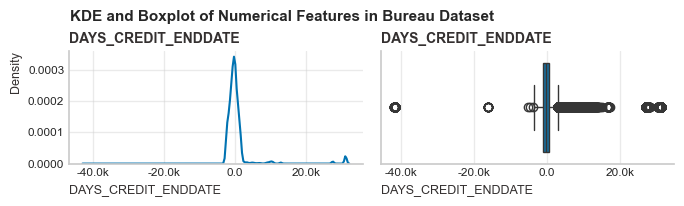

Missing Value Summary:
DAYS_CREDIT_ENDDATE: 105553 missing


,count,mean,std,min,25%,50%,75%,max
DAYS_CREDIT_ENDDATE,"1,610,875.0",510.5,"4,994.2","-42,060.0","-1,138.0",-330.0,474.0,"31,199.0"


In [67]:
utils.get_distribution_plots_with_stat(
    bureau_overview, ["DAYS_CREDIT_ENDDATE"], right=0.415, top=1.02
)

In [68]:
print(
    f"Minimum number of days credit ended: {bureau_overview.DAYS_CREDIT_ENDDATE.min()}"
)
print(
    f"Maximum number of days credit ended: {bureau_overview.DAYS_CREDIT_ENDDATE.max()}"
)
print(
    f"""Number of cases where days credit ended exceeds 27 years: 
      {bureau_overview[bureau_overview.DAYS_CREDIT_ENDDATE < -10_000].shape[0]}"""
)

Minimum number of days credit ended: -42060.0
Maximum number of days credit ended: 31199.0
Number of cases where days credit ended exceeds 27 years: 
      146


We will check how many records have DAYS_CREDIT_ENDDATE less than maximum DAYS_CREDIT to see if there are any inconsistencies.

In [69]:
enddate_min_day_anomaly = bureau_overview.DAYS_CREDIT_ENDDATE.lt(min_days_credit)
enddate_min_day_anomaly.value_counts()

DAYS_CREDIT_ENDDATE
False    1716278
True         150
Name: count, dtype: int64

We have got 150 cases that have this inconsistency.

In [70]:
bureau_overview[enddate_min_day_anomaly].head(2)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY,CRED_DEBT_LIMIT_MISMATCH_CRED_SUM,MISSING_CREDIT_LIMIT,CREDIT_SUM_OVERDUE_ANOMALY,DAYS_CRED_OVERDUE_MISMATCH,DAYS_UPDATE_ANOMALY,CREDIT_OVERDUE_ANOMALY
55561,324038,5233073,Active,currency 1,-841,0,-16322.0,NaN,0.0,0,0.0,264909.24,0.0,0.0,Credit card,-39.0,NaN,False,0,False,0,False,0,False,False,0,False,False,False,False
67507,147912,5007091,Active,currency 1,-388,0,-41847.0,NaN,0.0,0,225000.0,0.00,225000.0,0.0,Credit card,-241.0,NaN,False,0,False,0,False,0,False,True,0,False,False,False,False


Also we must check how many records have DAYS_CREDIT_ENDDATE less than DAYS_CREDIT.

In [71]:
enddate_anomaly = bureau_overview.DAYS_CREDIT_ENDDATE < bureau_overview.DAYS_CREDIT
enddate_anomaly.value_counts()

False    1716264
True         164
Name: count, dtype: int64

Now we can check how many samples have those two inconsistencies together.

In [72]:
enddate_logic_check = enddate_min_day_anomaly < enddate_anomaly
bureau_overview[enddate_logic_check].shape[0]

14

We will create a feature to represent this inconsistency and impute these anomalies with the DAYS_CREDIT.

In [73]:
bureau_overview["ENDDATE_ANOMALY"] = enddate_anomaly
bureau_overview.loc[enddate_anomaly, "DAYS_CREDIT_ENDDATE"] = np.nan
bureau_overview.loc[enddate_anomaly, "DAYS_CREDIT_ENDDATE"] = bureau_overview.loc[
    enddate_anomaly, "DAYS_CREDIT"
]

Additionally, we must check how many records have DAYS_CREDIT_ENDDATE very large number (greater than 20k days, which is about 55 years). We will create a feature to represent this anomaly and replace abnormal values with the median of the feature. We will create missing value indicator for this column as well.

In [74]:
bureau_overview[bureau_overview.DAYS_CREDIT_ENDDATE.gt(2e4)].head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY,CRED_DEBT_LIMIT_MISMATCH_CRED_SUM,MISSING_CREDIT_LIMIT,CREDIT_SUM_OVERDUE_ANOMALY,DAYS_CRED_OVERDUE_MISMATCH,DAYS_UPDATE_ANOMALY,CREDIT_OVERDUE_ANOMALY,ENDDATE_ANOMALY
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,180000.0,71017.38,108982.62,0.0,Credit card,-31.0,NaN,False,0,False,0,False,0,False,True,0,False,False,False,False,False
141,444864,5714639,Closed,currency 1,-2030,0,31111.0,-1750.0,NaN,0,85050.0,0.00,0.00,0.0,Credit card,-555.0,NaN,False,0,False,0,False,1,False,False,0,False,False,False,False,False
180,286014,5714690,Active,currency 1,-137,0,27460.0,NaN,0.0,0,22500.0,18765.63,76.59,0.0,Credit card,-31.0,NaN,False,0,False,0,False,0,False,False,0,False,False,False,False,False
241,228777,5714776,Active,currency 1,-1144,0,31081.0,NaN,NaN,0,225000.0,0.00,0.00,0.0,Credit card,-41.0,NaN,False,0,False,0,False,1,False,False,0,False,False,False,False,False
393,221368,5714983,Active,currency 1,-64,0,27460.0,NaN,0.0,0,22500.0,0.00,22500.00,0.0,Credit card,-17.0,NaN,False,0,False,0,False,0,False,True,0,False,False,False,False,False


In [75]:
extreme_enddate_anomaly = bureau_overview.DAYS_CREDIT_ENDDATE.gt(2e4)
bureau_overview["ENDDATE_EXTREME_ANOMALY"] = extreme_enddate_anomaly
bureau_overview.loc[extreme_enddate_anomaly, "DAYS_CREDIT_ENDDATE"] = np.nan
median_enddate = bureau_overview.DAYS_CREDIT_ENDDATE.median()
bureau_overview.loc[extreme_enddate_anomaly, "DAYS_CREDIT_ENDDATE"] = median_enddate

bureau_overview["MISSING_ENDDATE"] = (
    bureau_overview.DAYS_CREDIT_ENDDATE.isnull().astype(int)
)

**DAYS_ENDDATE_FACT**

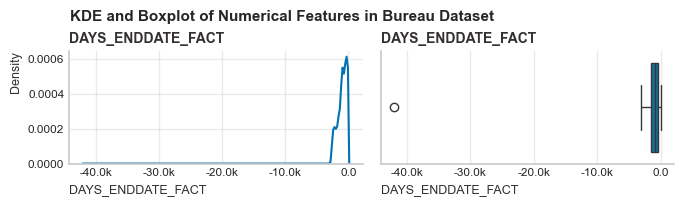

Missing Value Summary:
DAYS_ENDDATE_FACT: 633653 missing


,count,mean,std,min,25%,50%,75%,max
DAYS_ENDDATE_FACT,"1,082,775.0","-1,017.4",714.0,"-42,023.0","-1,489.0",-897.0,-425.0,0.0


In [76]:
utils.get_distribution_plots_with_stat(
    bureau_overview, ["DAYS_ENDDATE_FACT"], right=0.415, top=1.02
)

We will check a sample where DAYS_ENDDATE_FACT is less than 10k days (~27 years) to see if it is valid.

In [77]:
bureau_overview[bureau_overview.DAYS_ENDDATE_FACT.lt(-10_000)]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY,CRED_DEBT_LIMIT_MISMATCH_CRED_SUM,MISSING_CREDIT_LIMIT,CREDIT_SUM_OVERDUE_ANOMALY,DAYS_CRED_OVERDUE_MISMATCH,DAYS_UPDATE_ANOMALY,CREDIT_OVERDUE_ANOMALY,ENDDATE_ANOMALY,ENDDATE_EXTREME_ANOMALY,MISSING_ENDDATE
198346,104463,6550986,Closed,currency 1,-2340,0,-1836.0,-42023.0,0.0,0,225000.0,0.0,225000.0,0.0,Credit card,-2196.0,NaN,False,0,False,0,False,0,False,True,0,False,False,False,False,False,False,0


We see that for this sample DAYS_CREDIT are a shorter period than DAYS_ENDDATE_FACT. We will check this logic for all records.

In [78]:
enddate_fact_anomaly = bureau_overview.DAYS_ENDDATE_FACT < bureau_overview.DAYS_CREDIT
enddate_fact_anomaly.value_counts()

False    1716408
True          20
Name: count, dtype: int64

In [79]:
bureau_overview[enddate_fact_anomaly].head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY,CRED_DEBT_LIMIT_MISMATCH_CRED_SUM,MISSING_CREDIT_LIMIT,CREDIT_SUM_OVERDUE_ANOMALY,DAYS_CRED_OVERDUE_MISMATCH,DAYS_UPDATE_ANOMALY,CREDIT_OVERDUE_ANOMALY,ENDDATE_ANOMALY,ENDDATE_EXTREME_ANOMALY,MISSING_ENDDATE
152799,231661,6590817,Closed,currency 1,-1867,0,-314.0,-1911.0,NaN,0,157500.0,0.0,NaN,0.0,Consumer credit,-1812.0,0.0,False,0,False,0,False,1,False,False,1,False,False,False,False,False,False,0
159692,164981,5813026,Closed,currency 1,-1458,0,-1092.0,-1574.0,NaN,0,135000.0,0.0,0.0,0.0,Consumer credit,-1381.0,12474.0,False,0,False,0,False,1,False,False,0,False,False,False,False,False,False,0
197282,167355,6263598,Closed,currency 1,-1191,0,636.0,-2901.0,NaN,0,4500000.0,0.0,0.0,0.0,Consumer credit,-31.0,116239.5,False,0,False,0,False,1,False,False,0,False,False,False,False,False,False,0
198346,104463,6550986,Closed,currency 1,-2340,0,-1836.0,-42023.0,0.0,0,225000.0,0.0,225000.0,0.0,Credit card,-2196.0,NaN,False,0,False,0,False,0,False,True,0,False,False,False,False,False,False,0
210097,168249,6577480,Closed,currency 1,-1391,0,2277.0,-2632.0,NaN,0,2250000.0,0.0,0.0,0.0,Mortgage,-20.0,NaN,False,0,False,0,False,1,False,False,0,False,False,False,False,False,False,0


We have got 20 records with this inconsistency. We will create a feature to represent this inconsistency and impute these anomalies with the median of DAYS_ENDDATE_FACT. Additionally, we will create missing value indicator for this column as well.

In [80]:
bureau_overview["ENDDATE_FACT_ANOMALY"] = enddate_fact_anomaly
bureau_overview.loc[enddate_fact_anomaly, "DAYS_ENDDATE_FACT"] = np.nan
median_enddate_fact = bureau_overview.DAYS_ENDDATE_FACT.median()
bureau_overview.loc[enddate_fact_anomaly, "DAYS_ENDDATE_FACT"] = median_enddate_fact

bureau_overview["MISSING_ENDDATE_FACT"] = (
    bureau_overview.DAYS_ENDDATE_FACT.isnull().astype(int)
)

**AMT_ANNUITY**

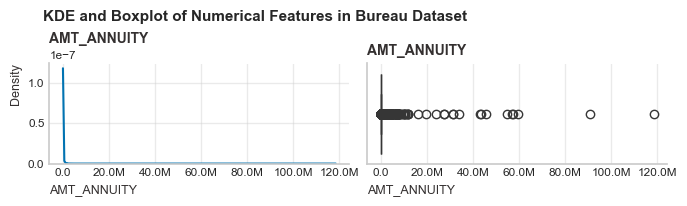

Missing Value Summary:
AMT_ANNUITY: 1226791 missing


,count,mean,std,min,25%,50%,75%,max
AMT_ANNUITY,"489,637.0","15,712.8","325,826.9",0.0,0.0,0.0,"13,500.0","118,453,423.5"


In [81]:
utils.get_distribution_plots_with_stat(
    bureau_overview, ["AMT_ANNUITY"], right=0.385, top=1.02
)

We see some extreme values of AMT_ANNUITY feature. We will examine a few of these records to see if they are valid. But first we will check credit distribution by credit type and credit status.

In [82]:
bureau_overview.CREDIT_TYPE.value_counts(normalize=True).map(lambda x: f"{x:.2%}")

CREDIT_TYPE
Consumer credit                                 72.92%
Credit card                                     23.43%
Car loan                                         1.61%
Mortgage                                         1.07%
Microloan                                        0.72%
Loan for business development                    0.12%
Another type of loan                             0.06%
Unknown type of loan                             0.03%
Loan for working capital replenishment           0.03%
Cash loan (non-earmarked)                        0.00%
Real estate loan                                 0.00%
Loan for the purchase of equipment               0.00%
Loan for purchase of shares (margin lending)     0.00%
Mobile operator loan                             0.00%
Interbank credit                                 0.00%
Name: proportion, dtype: object

In [83]:
bureau_overview.CREDIT_ACTIVE.value_counts(normalize=True).map(lambda x: f"{x:.2%}")

CREDIT_ACTIVE
Closed      62.88%
Active      36.74%
Sold         0.38%
Bad debt     0.00%
Name: proportion, dtype: object

We see that 73% of the credits are consumer credits, and 63% of them are closed.

We must check how many credits are active, have debt and annuity amount is zero.

In [84]:
bureau_overview[
    (bureau_overview["AMT_ANNUITY"] == 0)
    & (bureau_overview["CREDIT_ACTIVE"] == "Active")
    & (bureau_overview["AMT_CREDIT_SUM_DEBT"] > 0)
].head(5)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY,CRED_DEBT_LIMIT_MISMATCH_CRED_SUM,MISSING_CREDIT_LIMIT,CREDIT_SUM_OVERDUE_ANOMALY,DAYS_CRED_OVERDUE_MISMATCH,DAYS_UPDATE_ANOMALY,CREDIT_OVERDUE_ANOMALY,ENDDATE_ANOMALY,ENDDATE_EXTREME_ANOMALY,MISSING_ENDDATE,ENDDATE_FACT_ANOMALY,MISSING_ENDDATE_FACT
776,380361,5715457,Active,currency 1,-222,0,874.0,NaN,NaN,0,202500.0,31594.500,0.000,0.0,Credit card,-18.0,0.0,False,0,False,0,False,1,False,False,0,False,False,False,False,False,False,0,False,1
780,380361,5715461,Active,currency 1,-112,0,2445.0,NaN,NaN,0,2187000.0,2177275.500,NaN,0.0,Consumer credit,-8.0,0.0,False,0,False,0,False,1,False,False,1,False,False,False,False,False,False,0,False,1
791,399518,5715474,Active,currency 1,-896,0,NaN,NaN,NaN,0,397165.5,176967.000,NaN,0.0,Credit card,-6.0,0.0,False,0,False,0,False,1,False,False,1,False,False,False,False,False,False,1,False,1
899,190334,5715604,Active,currency 1,-372,0,935.0,NaN,NaN,0,225000.0,200002.500,0.000,0.0,Credit card,-30.0,0.0,False,0,False,0,False,1,False,False,0,False,False,False,False,False,False,0,False,1
1104,221655,5715834,Active,currency 1,-181,0,1665.0,NaN,NaN,0,45000.0,37197.585,7802.415,0.0,Credit card,-26.0,0.0,False,0,False,0,False,1,False,True,0,False,False,False,False,False,False,0,False,1


We will check very extreme values of AMT_ANNUITY to see if they are valid. We will take the 99.99th percentile as a threshold to mark anomalies.

In [85]:
bureau_overview[bureau_overview["AMT_ANNUITY"].gt(0.6e8)]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY,CRED_DEBT_LIMIT_MISMATCH_CRED_SUM,MISSING_CREDIT_LIMIT,CREDIT_SUM_OVERDUE_ANOMALY,DAYS_CRED_OVERDUE_MISMATCH,DAYS_UPDATE_ANOMALY,CREDIT_OVERDUE_ANOMALY,ENDDATE_ANOMALY,ENDDATE_EXTREME_ANOMALY,MISSING_ENDDATE,ENDDATE_FACT_ANOMALY,MISSING_ENDDATE_FACT
607473,300363,6466322,Closed,currency 1,-713,0,383.0,-299.0,NaN,0,2250000.0,0.0,0.0,0.0,Consumer credit,-296.0,118453423.5,False,0,False,0,False,1,False,False,0,False,False,False,False,False,False,0,False,0
1687167,448285,5574762,Closed,currency 1,-361,0,NaN,-356.0,NaN,0,13500.0,NaN,NaN,0.0,Consumer credit,-356.0,90632371.5,False,0,False,1,False,1,False,False,1,False,False,False,False,False,False,1,False,0


In [86]:
threshold_annuity = bureau_overview.AMT_ANNUITY.quantile(0.9999)
annuity_outlier = bureau_overview["AMT_ANNUITY"].gt(threshold_annuity)

print(
    f"Number of cases with extreme AMT_ANNUITY: {bureau_overview[annuity_outlier].shape[0]}."
)

Number of cases with extreme AMT_ANNUITY: 49.


In [87]:
bureau_overview[annuity_outlier].head(2)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY,CRED_DEBT_LIMIT_MISMATCH_CRED_SUM,MISSING_CREDIT_LIMIT,CREDIT_SUM_OVERDUE_ANOMALY,DAYS_CRED_OVERDUE_MISMATCH,DAYS_UPDATE_ANOMALY,CREDIT_OVERDUE_ANOMALY,ENDDATE_ANOMALY,ENDDATE_EXTREME_ANOMALY,MISSING_ENDDATE,ENDDATE_FACT_ANOMALY,MISSING_ENDDATE_FACT
26836,248016,5202773,Closed,currency 1,-140,0,408.0,-45.0,0.0,0,6750000.0,0.0,0.0,0.0,Consumer credit,-45.0,6578707.5,False,0,False,0,False,0,False,False,0,False,False,False,False,False,False,0,False,0
124108,326023,5241861,Closed,currency 1,-2273,0,5093.0,-760.0,NaN,0,7464429.0,0.0,0.0,0.0,Mortgage,-756.0,7217253.0,False,0,False,0,False,1,False,False,0,False,False,False,False,False,False,0,False,0


Also we should check how many records have AMT_ANNUITY greater than AMT_CREDIT_SUM.

In [88]:
annuity_anomaly = bureau_overview.AMT_ANNUITY > bureau_overview.AMT_CREDIT_SUM
annuity_anomaly.value_counts()

False    1703954
True       12474
Name: count, dtype: int64

In [89]:
bureau_overview[annuity_anomaly].head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_SUM_ANOMALY,MISSING_CREDIT_SUM,CREDIT_SUM_DEBT_ANOMALY,MISSING_CREDIT_SUM_DEBT,MAX_OVERDUE_ANOMALY,MISSING_MAX_OVERDUE,OVERDUE_ANOMALY,CRED_DEBT_LIMIT_MISMATCH_CRED_SUM,MISSING_CREDIT_LIMIT,CREDIT_SUM_OVERDUE_ANOMALY,DAYS_CRED_OVERDUE_MISMATCH,DAYS_UPDATE_ANOMALY,CREDIT_OVERDUE_ANOMALY,ENDDATE_ANOMALY,ENDDATE_EXTREME_ANOMALY,MISSING_ENDDATE,ENDDATE_FACT_ANOMALY,MISSING_ENDDATE_FACT
790,399518,5715473,Closed,currency 1,-941,0,NaN,-823.0,NaN,0,0.00,0.0,NaN,0.0,Credit card,-466.0,8061.210,False,0,False,0,False,1,False,False,1,False,False,False,False,False,False,1,False,0
822,298038,5715510,Closed,currency 1,-586,0,-339.0,-553.0,0.0,0,40791.33,0.0,0.0,0.0,Consumer credit,-553.0,67995.000,False,0,False,0,False,0,False,False,0,False,False,False,False,False,False,0,False,0
836,311464,5715527,Closed,currency 1,-1352,0,NaN,-1209.0,0.0,0,0.00,0.0,0.0,0.0,Credit card,-410.0,10491.885,False,0,False,0,False,0,False,True,0,False,False,False,False,False,False,1,False,0
1014,220033,5715734,Closed,currency 1,-69,0,-52.0,-52.0,0.0,0,18405.00,0.0,0.0,0.0,Microloan,-49.0,23790.015,False,0,False,0,False,0,False,False,0,False,False,False,False,False,False,0,False,0
1041,237164,5715763,Closed,currency 1,-1098,0,-8.0,-518.0,NaN,0,0.00,0.0,0.0,0.0,Credit card,-499.0,42750.000,False,0,False,0,False,1,False,True,0,False,False,False,False,False,False,0,False,0


We will make broader grouping of credit types to see if there are any patterns in annuity vs credit sum. We will clip annuity amounts to the 99.99th percentile and create an indicator where AMT_ANNUITY is greater than AMT_CREDIT_SUM. 

We will add indicator were credit is active, has debt and annuity amount is zero as well.

Finally, we will impute missing values of AMT_ANNUITY with median value of the feature according to the CREDIT_TYPE_GROUP.

In [90]:
bureau_overview["CREDIT_TYPE_GROUPED"] = bureau_overview["CREDIT_TYPE"].apply(
    utils.consolidate_credit_type
)

bureau_overview["AMT_ANNUITY"] = bureau_overview["AMT_ANNUITY"].clip(
    upper=threshold_annuity
)

anomalous_annuity = bureau_overview["AMT_ANNUITY"] > bureau_overview["AMT_CREDIT_SUM"]
bureau_overview["ANNUITY_ANOMALY"] = anomalous_annuity.astype(int)
bureau_overview.loc[anomalous_annuity, ["AMT_ANNUITY"]] = np.nan

In [91]:
installment_group_types = [
    "Installment_Unsecured",
    "Secured_Installment",
    "Business_Loan",
]

installment_zero_annuity = (
    (bureau_overview["AMT_ANNUITY"] == 0)
    & (bureau_overview["CREDIT_ACTIVE"] == "Active")
    & (bureau_overview["AMT_CREDIT_SUM_DEBT"] > 0)
    & (bureau_overview["CREDIT_TYPE_GROUPED"].isin(installment_group_types))
)

revolving_zero_annuity = (
    (bureau_overview["AMT_ANNUITY"] == 0)
    & (bureau_overview["CREDIT_ACTIVE"] == "Active")
    & (bureau_overview["AMT_CREDIT_SUM_DEBT"] > 0)
    & (bureau_overview["CREDIT_TYPE_GROUPED"] == "Revolving")
)

annuity_to_impute = installment_zero_annuity | revolving_zero_annuity

bureau_overview["ANNUITY_ZER_FLAG"] = annuity_to_impute.astype(int)

bureau_overview.loc[annuity_to_impute, "AMT_ANNUITY"] = np.nan

bureau_overview["AMT_ANNUITY"] = bureau_overview.groupby("CREDIT_TYPE_GROUPED")[
    "AMT_ANNUITY"
].transform(lambda x: x.fillna(x.median()))

Further, we will create some additional features based on bureau.csv data to capture important aspects of clients' previous credits: ratios, differences and flags.

In [92]:
bureau_overview["DEBT_TO_CREDIT_RATIO"] = bureau_overview["AMT_CREDIT_SUM_DEBT"] / (
    bureau_overview["AMT_CREDIT_SUM"] + 1e-5
)
bureau_overview["OVERDUE_TO_DEBT_RATIO"] = bureau_overview["AMT_CREDIT_MAX_OVERDUE"] / (
    bureau_overview["AMT_CREDIT_SUM_DEBT"] + 1e-5
)
bureau_overview["ANNUITY_TO_CREDIT_RATIO"] = bureau_overview["AMT_ANNUITY"] / (
    bureau_overview["AMT_CREDIT_SUM"] + 1e-5
)
bureau_overview["CREDIT_TO_LIMIT_RATIO"] = bureau_overview["AMT_CREDIT_SUM"] / (
    bureau_overview["AMT_CREDIT_SUM_LIMIT"] + 1e-5
)
bureau_overview["CREDIT_DURATION_PLAN"] = (
    bureau_overview["DAYS_CREDIT_ENDDATE"] - bureau_overview["DAYS_CREDIT"]
)
bureau_overview["CREDIT_DURATION_FACT"] = (
    bureau_overview["DAYS_ENDDATE_FACT"] - bureau_overview["DAYS_CREDIT"]
)
bureau_overview["CREDIT_DURATION_DIFF"] = (
    bureau_overview["CREDIT_DURATION_PLAN"] - bureau_overview["CREDIT_DURATION_FACT"]
)
bureau_overview["CREDIT_TO_ANNUITY_RATIO"] = bureau_overview["AMT_CREDIT_SUM"] / (
    bureau_overview["AMT_ANNUITY"] + 1e-5
)
bureau_overview["HAS_OVERDUE"] = (bureau_overview["AMT_CREDIT_MAX_OVERDUE"] > 0).astype(
    int
)
bureau_overview["CREDIT_TO_ANNUITY_RATIO"] = bureau_overview["AMT_CREDIT_SUM"] / (
    bureau_overview["AMT_ANNUITY"] + 1e-5
)

In [93]:
print(
    f"""The shape of bureau_overview table after analysis and feature 
engineering is {bureau_overview.shape}."""
)

The shape of bureau_overview table after analysis and feature 
engineering is (1716428, 47).


Now we will join bureau_bal_summary aggregated table with bureau_overview table to get a complete view of clients' previous credits along with their monthly status information.

In [94]:
bureau_data = con.execute(
    """SELECT *
            FROM bureau_overview
            LEFT JOIN bureau_bal_summary
            USING(SK_ID_BUREAU)
            """
).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [95]:
print(f"Final bureau_data table has the shape: {bureau_data.shape}.")

Final bureau_data table has the shape: (1716428, 72).


##### **FINAL AGGREGATION** #####

Lastly, we will aggregate burea_data table by SK_ID_CURR to be it prepared for merging with main application data.

In [96]:
bureau_agg_summary = con.execute(
    """
                  SELECT SK_ID_CURR,
                  
                  COUNT(SK_ID_BUREAU) AS BUREAU_CREDIT_COUNT,
                  
                  AVG(DAYS_CREDIT) AS BUREAU_AVG_DAYS_CREDIT,
                  MIN(DAYS_CREDIT) AS BUREAU_EARLIEST_DAYS_CREDIT,
                  (MIN(DAYS_CREDIT) - MAX(DAYS_CREDIT)) AS BUREAU_CREDIT_HISTORY_SPAN,
                  
                  MAX(CREDIT_DAY_OVERDUE) AS BUREAU_MAX_CREDIT_DAY_OVERDUE,
                  AVG(CREDIT_DAY_OVERDUE) AS BUREAU_AVG_CREDIT_DAY_OVERDUE,
                  
                  AVG(DAYS_CREDIT_ENDDATE) AS BUREAU_AVG_DAYS_CREDIT_ENDDATE,
                  MAX(DAYS_CREDIT_ENDDATE) AS BUREAU_MAX_DAYS_CREDIT_ENDDATE,
                  AVG(DAYS_ENDDATE_FACT) AS BUREAU_AVG_DAYS_ENDDATE_FACT,
                  MAX(AMT_CREDIT_MAX_OVERDUE) AS BUREAU_MAX_AMT_CREDIT_MAX_OVERDUE,
                  
                  MAX(CNT_CREDIT_PROLONG) AS BUREAU_MAX_CNT_CREDIT_PROLONG,
                  SUM(CNT_CREDIT_PROLONG) AS BUREAU_SUM_CREDIT_PROLONG,
                  SUM(AMT_CREDIT_SUM) AS BUREAU_TOTAL_CREDIT_SUM,
                  MEDIAN(AMT_CREDIT_SUM) AS BUREAU_MEDIAN_CREDIT_SUM,
                  MAX(AMT_CREDIT_SUM) AS BUREAU_MAX_CREDIT_SUM,
                  STDDEV(AMT_CREDIT_SUM) AS BUREAU_STD_CREDIT_SUM,
                  
                  SUM(AMT_CREDIT_SUM_DEBT) AS BUREAU_TOTAL_CREDIT_SUM_DEBT,
                  MAX(AMT_CREDIT_SUM_DEBT) AS BUREAU_MAX_CREDIT_SUM_DEBT,
                  MEDIAN(AMT_CREDIT_SUM_DEBT) AS BUREAU_MEDIAN_CREDIT_SUM_DEBT,
                  AVG(AMT_CREDIT_SUM) / NULLIF(AVG(AMT_CREDIT_SUM_DEBT), 0) AS BUREAU_AVG_CREDIT_DEBT_RATIO,
                  SUM(AMT_CREDIT_SUM_LIMIT) AS BUREAU_TOTAL_CREDIT_LIMIT,
                  SUM(AMT_CREDIT_SUM_OVERDUE) AS BUREAU_TOTAL_CREDIT_SUM_OVERDUE,
                  MAX(AMT_CREDIT_SUM_OVERDUE) AS BUREAU_MAX_CREDIT_SUM_OVERDUE,
                  AVG(DAYS_CREDIT_UPDATE) AS BUREAU_AVG_DAYS_CREDIT_UPDATE,
                  AVG(AMT_ANNUITY) AS BUREAU_AVG_AMT_ANNUITY,
                  
                  SUM(CREDIT_SUM_ANOMALY) AS BUREAU_CREDIT_SUM_TOTAL_ANOMALY,
                  SUM(MISSING_CREDIT_SUM) AS BUREAU_TOTAL_MISSING_CREDIT_SUM,
                  SUM(CREDIT_SUM_DEBT_ANOMALY) AS BUREAU_CREDIT_DEBT_TOTAL_ANOMALY,
                  SUM(MISSING_CREDIT_SUM_DEBT) AS BUREAU_TOTAL_MISSING_CREDIT_SUM_DEBT,
                  SUM(OVERDUE_ANOMALY) AS BUREAU_SUM_OVERDUE_ANOMALY,
                  SUM(MAX_OVERDUE_ANOMALY) AS BUREAU_SUM_MAX_OVERDUE_ANOMALY,
                  SUM(MISSING_MAX_OVERDUE) AS BUREAU_SUM_MISSING_MAX_OVERDUE,
                  SUM(CRED_DEBT_LIMIT_MISMATCH_CRED_SUM) AS BUREAU_SUM_CRED_DEBT_LIMIT_MISMATCH,
                  SUM(MISSING_CREDIT_LIMIT) AS BUREAU_SUM_MISSING_CREDIT_LIMIT,
                  SUM(CREDIT_SUM_OVERDUE_ANOMALY) AS BUREAU_SUM_CREDIT_SUM_OVERDUE_ANOMALY,
                  SUM(DAYS_CRED_OVERDUE_MISMATCH) AS BUREAU_SUM_DAYS_CRED_OVERDUE_MISMATCH,
                  SUM(DAYS_UPDATE_ANOMALY) AS BUREAU_SUM_DAYS_UPDATE_ANOMALY,
                  SUM(CREDIT_OVERDUE_ANOMALY) AS BUREAU_SUM_CREDIT_OVERDUE_ANOMALY,
                  SUM(ENDDATE_ANOMALY) AS BUREAU_SUM_ENDDATE_ANOMALY,
                  SUM(ENDDATE_EXTREME_ANOMALY) AS BUREAU_SUM_ENDDATE_EXTREME_ANOMALY,
                  SUM(MISSING_ENDDATE) AS BUREAU_SUM_MISSING_ENDDATE,
                  SUM(ENDDATE_FACT_ANOMALY) AS BUREAU_SUM_ENDDATE_FACT_ANOMALY,
                  SUM(MISSING_ENDDATE_FACT) AS BUREAU_SUM_MISSING_ENDDATE_FACT,
                  SUM(ANNUITY_ANOMALY) AS BUREAU_SUM_ANNUITY_ANOMALY,
                  SUM(ANNUITY_ZER_FLAG) AS BUREAU_SUM_ANNUITY_ZERO_FLAG,
                  SUM(HAS_OVERDUE) AS BUREAU_SUM_HAS_OVERDUE,
                  
                  AVG(DEBT_TO_CREDIT_RATIO) AS BUREAU_AVG_DEBT_TO_CREDIT_RATIO,
                  
                  AVG(OVERDUE_TO_DEBT_RATIO) AS BUREAU_AVG_OVERDUE_TO_DEBT_RATIO,
                  STDDEV(DEBT_TO_CREDIT_RATIO) AS BUREAU_STD_DEBT_TO_CREDIT_RATIO,
                  AVG(ANNUITY_TO_CREDIT_RATIO) AS BUREAU_AVG_ANNUITY_TO_CREDIT_RATIO,
                  AVG(CREDIT_TO_LIMIT_RATIO) AS BUREAU_AVG_CREDIT_TO_LIMIT_RATIO,
                  AVG(CREDIT_DURATION_PLAN) AS BUREAU_AVG_CREDIT_DURATION_PLAN,
                  AVG(CREDIT_DURATION_FACT) AS BUREAU_AVG_CREDIT_DURATION_FACT,
                  AVG(CREDIT_DURATION_DIFF) AS BUREAU_AVG_CREDIT_DURATION_DIFF,
                  AVG(CREDIT_TO_ANNUITY_RATIO) AS BUREAU_AVG_CREDIT_TO_ANNUITY_RATIO,
                  AVG(HAS_OVERDUE) AS BUREAU_HAS_OVERDUE_RATIO,
                  MIN(CASE WHEN HAS_OVERDUE = 1 THEN DAYS_CREDIT_UPDATE END) AS BUREAU_DAYS_LAST_OVERDUE,
                  MAX(DAYS_CREDIT_ENDDATE) - AVG(DAYS_CREDIT) AS BUREAU_MAX_ENDDATE_CREDIT_AGE_DIFF,
                  
                  MAX(DEBT_TO_CREDIT_RATIO) AS BUREAU_MAX_DEBT_TO_CREDIT_RATIO,
                  MIN(DEBT_TO_CREDIT_RATIO) AS BUREAU_MIN_DEBT_TO_CREDIT_RATIO,
                  MAX(OVERDUE_TO_DEBT_RATIO) AS BUREAU_MAX_OVERDUE_TO_DEBT_RATIO,
                  MIN(OVERDUE_TO_DEBT_RATIO) AS BUREAU_MIN_OVERDUE_TO_DEBT_RATIO,
                  MAX(CREDIT_DURATION_DIFF) AS BUREAU_MAX_CREDIT_DURATION_DIFF,
                  
                  -- Aggregations on count and ratio features
                  SUM(MONTHS_COUNT) AS BUREAU_SUM_MONTHS_COUNT,
                  SUM(CLOSED_COUNT) AS BUREAU_SUM_CLOSED_COUNT,
                  SUM(UNKNOWN_COUNT) AS BUREAU_SUM_UNKNOWN_COUNT,
                  SUM(ON_TIME_COUNT) AS BUREAU_SUM_ON_TIME_COUNT,
                  SUM(DPD_1_30_COUNT) AS BUREAU_SUM_DPD_1_30_COUNT,
                  SUM(DPD_31_60_COUNT) AS BUREAU_SUM_DPD_31_60_COUNT,
                  SUM(DPD_61_90_COUNT) AS BUREAU_SUM_DPD_61_90_COUNT,
                  SUM(DPD_91_120_COUNT) AS BUREAU_SUM_DPD_91_120_COUNT,
                  SUM(DPD_120_COUNT) AS BUREAU_SUM_DPD_120_COUNT,
                  SUM(TOTAL_DPD_COUNT) AS BUREAU_SUM_TOTAL_DPD_COUNT,
                  AVG(CLOSED_RATIO) AS BUREAU_AVG_CLOSED_RATIO,
                  AVG(UNKNOWN_RATIO) AS BUREAU_AVG_UNKNOWN_RATIO,
                  AVG(ON_TIME_RATIO) AS BUREAU_AVG_ON_TIME_RATIO,
                  AVG(DPD_1_30_RATIO) AS BUREAU_AVG_DPD_1_30_RATIO,
                  AVG(DPD_31_60_RATIO) AS BUREAU_AVG_DPD_31_60_RATIO,
                  AVG(DPD_61_90_RATIO) AS BUREAU_AVG_DPD_61_90_RATIO,
                  AVG(DPD_91_120_RATIO) AS BUREAU_AVG_DPD_91_120_RATIO,
                  AVG(DPD_120_RATIO) AS BUREAU_AVG_DPD_120_RATIO,
                  AVG(TOTAL_DPD_RATIO) AS BUREAU_AVG_TOTAL_DPD_RATIO,
                  MAX(TOTAL_DPD_RATIO) AS BUREAU_MAX_TOTAL_DPD_RATIO,

                  -- First and last DPD months
                  MIN(FIRST_DPD_MONTH) AS BUREAU_MIN_FIRST_DPD_MONTH,
                  MAX(LAST_DPD_MONTH) AS BUREAU_MAX_LAST_DPD_MONTH,
                  
                  -- Aggregations on balance months
                  MIN(MIN_MONTHS_BALANCE) AS BUREAU_MIN_MONTHS_BALANCE,
                  MAX(MAX_MONTHS_BALANCE) AS BUREAU_MAX_MONTHS_BALANCE,
                  AVG(MAX_MIN_MONTHS_DIFF) AS BUREAU_AVG_MAX_MIN_MONTHS_DIFF,

                  -- Categorical feature counts
                  COUNT(CASE WHEN CREDIT_ACTIVE = 'Active' THEN 1 ELSE NULL END) AS BUREAU_ACTIVE_CREDITS,
                  COUNT(CASE WHEN CREDIT_ACTIVE = 'Closed' THEN 1 ELSE NULL END) AS BUREAU_CLOSED_CREDITS,
                  COUNT(CASE WHEN CREDIT_ACTIVE = 'Sold' THEN 1 ELSE NULL END) AS BUREAU_SOLD_CREDITS,
                  COUNT(CASE WHEN CREDIT_ACTIVE = 'Bad debt' THEN 1 ELSE NULL END) AS BUREAU_BAD_DEBT_CREDITS,
                  
                  AVG(CASE WHEN CREDIT_ACTIVE = 'Active' THEN 1 ELSE 0 END) AS BUREAU_ACTIVE_CREDIT_RATIO,
                  AVG(CASE WHEN CREDIT_ACTIVE = 'Closed' THEN 1 ELSE 0 END) AS BUREAU_CLOSED_CREDIT_RATIO,
                  AVG(CASE WHEN CREDIT_ACTIVE = 'Sold' THEN 1 ELSE 0 END) AS BUREAU_SOLD_CREDIT_RATIO,
                  AVG(CASE WHEN CREDIT_ACTIVE = 'Bad debt' THEN 1 ELSE 0 END) AS BUREAU_BAD_DEBT_CREDIT_RATIO,

                  -- Count of each credit type grouped
                  COUNT(CASE WHEN CREDIT_TYPE_GROUPED = 'Installment_Unsecured' THEN 1 ELSE NULL END) AS BUREAU_INSTALLMENT_UNSECURED_COUNT,
                  COUNT(CASE WHEN CREDIT_TYPE_GROUPED = 'Revolving' THEN 1 ELSE NULL END) AS BUREAU_REVOLVING_CREDIT_COUNT,
                  COUNT(CASE WHEN CREDIT_TYPE_GROUPED = 'Secured_Installment' THEN 1 ELSE NULL END) AS BUREAU_SECURED_INSTALLMENT_COUNT,
                  COUNT(CASE WHEN CREDIT_TYPE_GROUPED = 'Business_Loan' THEN 1 ELSE NULL END) AS BUREAU_BUSINESS_LOAN_COUNT,
                  COUNT(CASE WHEN CREDIT_TYPE_GROUPED = 'Other_Unknown' THEN 1 ELSE NULL END) AS BUREAU_OTHER_UNKNOWN_COUNT,
                  
                  -- Count of each credit currency
                  COUNT(CASE WHEN CREDIT_CURRENCY = 'currency 1' THEN 1 ELSE NULL END) AS BUREAU_CURRENCY_1_COUNT,
                  COUNT(CASE WHEN CREDIT_CURRENCY = 'currency 2' THEN 1 ELSE NULL END) AS BUREAU_CURRENCY_2_COUNT,
                  COUNT(CASE WHEN CREDIT_CURRENCY = 'currency 3' THEN 1 ELSE NULL END) AS BUREAU_CURRENCY_3_COUNT,
                  COUNT(CASE WHEN CREDIT_CURRENCY = 'currency 4' THEN 1 ELSE NULL END) AS BUREAU_CURRENCY_4_COUNT,
                  COUNT(DISTINCT CREDIT_CURRENCY) AS BUREAU_COUNT_DISTINCT_CURRENCY
                FROM
                  bureau_data
                GROUP BY
                  SK_ID_CURR
                 ;"""
).df()

In [97]:
print(
    f"Final shape of the aggregated bureau summary table is: {bureau_agg_summary.shape}."
)

Final shape of the aggregated bureau summary table is: (305811, 107).


Below we will inspect how many missing values are present in the final aggregated bureau_agg_summary table.

In [98]:
missing_values_burea_agg = bureau_agg_summary.isnull().sum()
missing_values_burea_agg[missing_values_burea_agg > 0]

BUREAU_AVG_DAYS_CREDIT_ENDDATE          2585
BUREAU_MAX_DAYS_CREDIT_ENDDATE          2585
BUREAU_AVG_DAYS_ENDDATE_FACT           37656
BUREAU_MAX_AMT_CREDIT_MAX_OVERDUE      92954
BUREAU_TOTAL_CREDIT_SUM                    2
BUREAU_MEDIAN_CREDIT_SUM                   2
BUREAU_MAX_CREDIT_SUM                      2
BUREAU_STD_CREDIT_SUM                  41521
BUREAU_TOTAL_CREDIT_SUM_DEBT            8372
BUREAU_MAX_CREDIT_SUM_DEBT              8372
BUREAU_MEDIAN_CREDIT_SUM_DEBT           8372
BUREAU_AVG_CREDIT_DEBT_RATIO           89027
BUREAU_TOTAL_CREDIT_LIMIT              25308
BUREAU_AVG_DEBT_TO_CREDIT_RATIO         8374
BUREAU_AVG_OVERDUE_TO_DEBT_RATIO      109166
BUREAU_STD_DEBT_TO_CREDIT_RATIO        56662
BUREAU_AVG_ANNUITY_TO_CREDIT_RATIO         2
BUREAU_AVG_CREDIT_TO_LIMIT_RATIO       25308
BUREAU_AVG_CREDIT_DURATION_PLAN         2585
BUREAU_AVG_CREDIT_DURATION_FACT        37656
BUREAU_AVG_CREDIT_DURATION_DIFF        39403
BUREAU_AVG_CREDIT_TO_ANNUITY_RATIO         2
BUREAU_DAY

Since missing values for COUNT and SUM aggregations could be treated as zeros, we will fill them with zeros. For MEAN, MAX, MIN aggregations we will leave missing values as is for now.

In [99]:
zero_fill_cols = [
    col for col in bureau_agg_summary.columns if "COUNT" in col or "SUM_" in col
]

bureau_agg_summary[zero_fill_cols] = bureau_agg_summary[zero_fill_cols].fillna(0)

Finally, we will load to Parquet file the final aggregated bureau_agg_summary table to be used in further analysis and modeling.

In [100]:
bureau_file_path = "../data/processed/bureau_table_v3.parquet"
# bureau_agg_summary.to_parquet(bureau_file_path, index=False)
print(f"Dataframe saved to {bureau_file_path}.")

Dataframe saved to ../data/processed/bureau_table_v3.parquet.
